# Portfolio Optimization

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from data_processing import * 
from forecasting import *
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [5]:
tsla = read_file('tsla')
bnd = read_file('bnd')
spy = read_file('spy')

In [7]:
tsla.tail()

,Price
Date,
2024-10-24 00:00:00+00:00,260.480011
2024-10-25 00:00:00+00:00,269.190002
2024-10-28 00:00:00+00:00,262.510010
2024-10-29 00:00:00+00:00,259.519989
2024-10-30 00:00:00+00:00,257.549988


In [8]:
model_path = '../models/best_model.pkl'
lstm_model = joblib.load(model_path)
num_prediction = 365
look_back = 60

In [9]:
tsla_forecast, forecast_dates = predict(tsla,look_back,num_prediction, lstm_model)
forecast_byd, forecast_dates = predict(bnd,look_back,num_prediction, lstm_model)
forecast_spy, forecast_dates = predict(spy,look_back,num_prediction, lstm_model)

In [10]:
forecast_df = pd.DataFrame({
    "TSLA": tsla_forecast.ravel(),  # From Task 3
    "BND": forecast_byd.ravel(),     # BND forecast results
    "SPY": forecast_spy.ravel()      # SPY forecast results
}, index=forecast_dates)


In [12]:
forecast_df.head(3)

,TSLA,BND,SPY
2024-10-30 00:00:00.000000001,257.549988,73.059998,580.010010
2024-10-31 00:00:00.000000001,255.997000,73.411022,564.353218
2024-11-01 00:00:00.000000001,260.325507,73.388779,561.907287


In [13]:
forecast_df.tail(3)

,TSLA,BND,SPY
2025-10-28 00:00:00.000000001,288.813710,82.991914,463.029384
2025-10-29 00:00:00.000000001,288.813710,82.991933,463.029384
2025-10-30 00:00:00.000000001,288.813734,82.991953,463.029408


In [14]:
forecast_df.shape

(366, 3)

In [16]:
returns_df = forecast_df.pct_change().dropna()

In [17]:
annual_returns = returns_df.mean() * 366  


In [19]:
annual_returns

TSLA    0.115275
BND     0.127868
SPY    -0.224948
dtype: float64

In [24]:
covariance_matrix = returns_df.cov() * 252
covariance_matrix

,TSLA,BND,SPY
TSLA,0.000522,-0.000009,-0.000290
BND,-0.000009,0.000047,-0.000123
SPY,-0.000290,-0.000123,0.001168


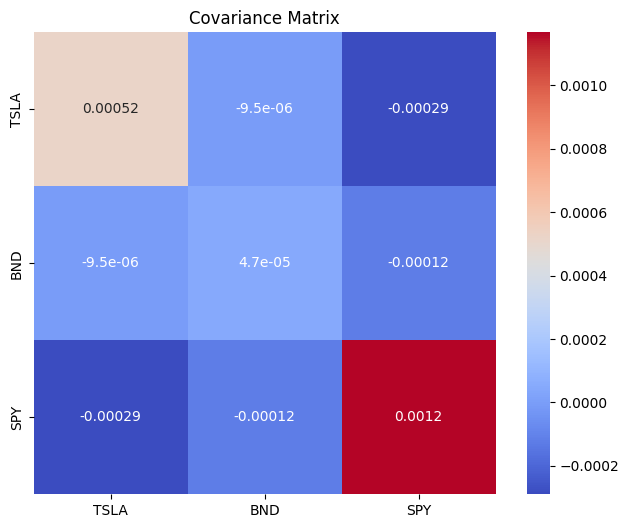

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Plot the covariance matrix
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', square=True, cbar=True)

# Add titles and labels
plt.title('Covariance Matrix')
plt.show()

In [25]:

# Initial weights
num_assets = len(returns_df.columns)
weights = np.ones(num_assets) / num_assets

In [26]:
def portfolio_performance(weights, returns, cov_matrix, risk_free_rate=0.03):
    portfolio_return = np.dot(weights, returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return portfolio_return, portfolio_std_dev, sharpe_ratio


In [27]:
from scipy.optimize import minimize

# Define objective function
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.03):
    return -portfolio_performance(weights, returns, cov_matrix, risk_free_rate)[2]  # Negative for maximization

# Constraints: Sum of weights is 1, bounds are [0,1] for each asset
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Optimization
optimized = minimize(neg_sharpe_ratio, weights, args=(annual_returns, covariance_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized.x


In [28]:
optimal_weights

array([0.09493525, 0.86921395, 0.03585079])

In [29]:
portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_performance(optimal_weights, annual_returns, covariance_matrix)


In [30]:
portfolio_return, portfolio_volatility, sharpe_ratio

(0.11402389681289725, 0.005520870775309265, 15.219319602384724)

In [25]:
import scipy.stats as stats

confidence_level = 0.95
z_score = stats.norm.ppf(1 - confidence_level)
var_tesla = annual_returns["TSLA"] + z_score * np.sqrt(covariance_matrix.loc["TSLA", "TSLA"])


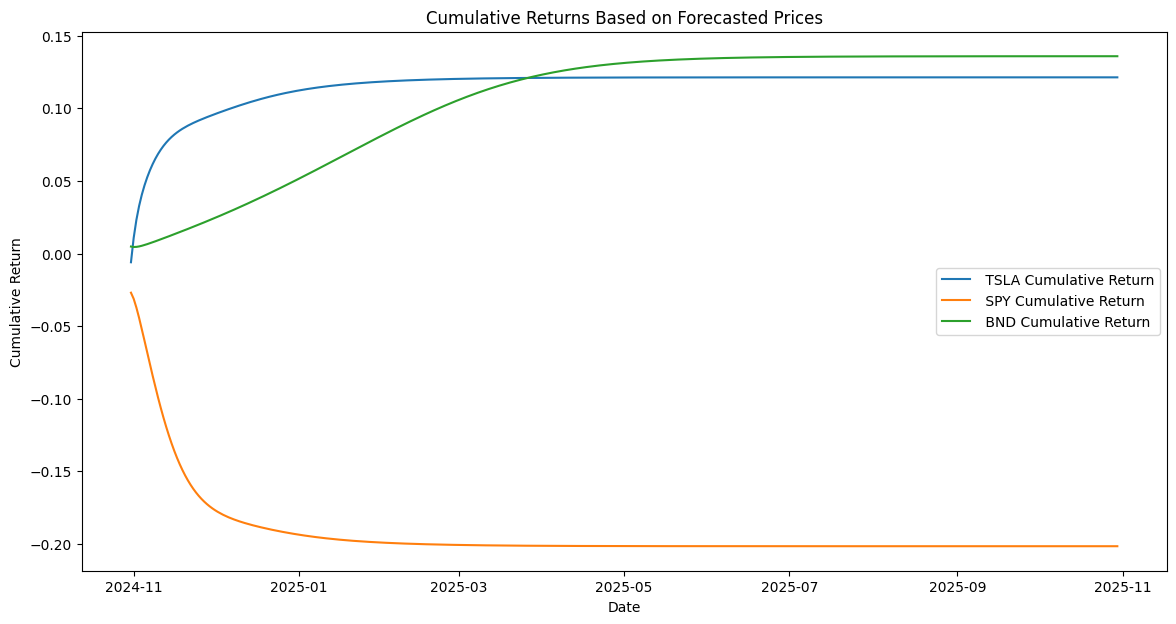

In [33]:
cumulative_returns = (1 + returns_df).cumprod() - 1
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns['TSLA'], label=" TSLA Cumulative Return")
plt.plot(cumulative_returns['SPY'], label=" SPY Cumulative Return")
plt.plot(cumulative_returns['BND'], label=" BND Cumulative Return")
plt.title("Cumulative Returns Based on Forecasted Prices")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


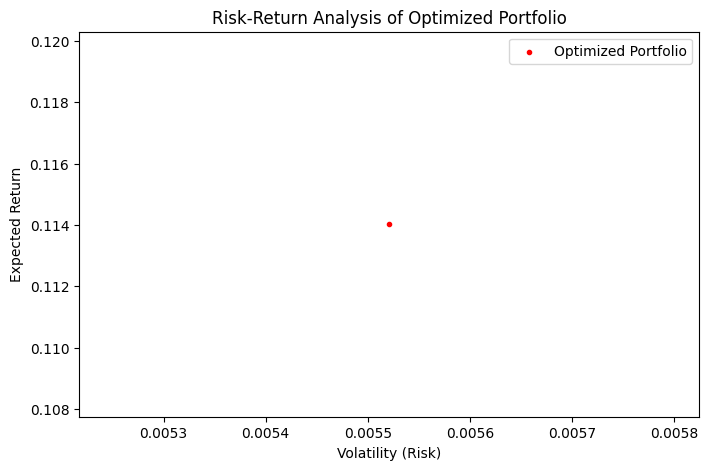

In [30]:
plt.figure(figsize=(8, 5))
plt.scatter(portfolio_volatility, portfolio_return, color="red", marker=".", label="Optimized Portfolio")
plt.title("Risk-Return Analysis of Optimized Portfolio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.legend()
plt.show()


In [31]:
portfolio_volatility, portfolio_return

(0.005520870775309265, 0.11402389681289725)